## Derivative examples


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x) :
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5 , 5 , 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

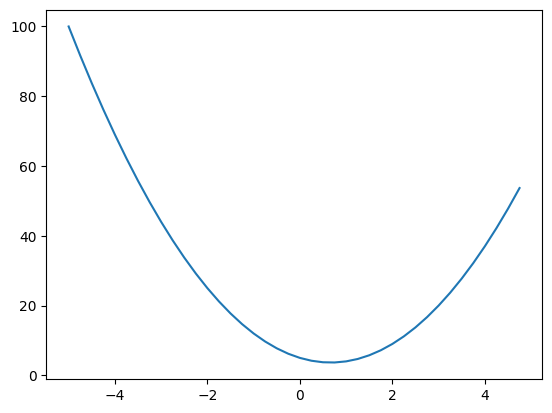

In [5]:
ys = f(xs)
plt.plot(xs , ys)

In [6]:
# derivative how much solpe bumps up if we change small value
# lim h->0 f(x + h) - f(x) /  h  , /h is to normalize value
# it also gives direction in which change takes place
h = 0.000000001
x = 3.0
print((f(x + h) - f(x))/h)
x = -3
print((f(x + h) - f(x))/h)
x = 2/3
print((f(x + h) - f(x))/h)

14.000001158365194
-22.000001820288162
0.0


In [7]:
# how to compute derivative for a equation wrt a particular variable

a = 2.0
b = -3.0
c = 10.0
d = a*b + c

# find derivative of d wrt a => dd/da
h = 0.000001

d1 = a*b + c    # old d value
a += h          # add h to a
d2 = a*b + c    # new d value

print("derivative : " , (d2 - d1)/h)

# dd/da = b (by calculus) approx -3.0000 our result

derivative :  -3.000000000419334


## Value Data strucutre / compute unit

In [108]:
# Now NN is similar , every layer forms equations
# backprop => derivative of Loss fun wrt to weights .
# we need a data structure to keep track of computations that led to curr node , by which operations
# children  ex : a = b*c  , a's children = (Value(b) , Value(c))
# op     => '*' (b * c) produced by * of b and c .
# as b , c are also value we can recusively get all data of equation from which they were formed


class Value:
    def __init__(self , data , _children = () , _op = '' , label = '') :
        self.data = data
        self._prev = set(_children)
        self._op  = _op
        self.label = label
        self.grad = 0
        # for backprop
        self._backward = lambda : None

    def backward(self) :
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            print(v , end = " ")
            v._backward()


    def __repr__(self) :
        return f"Value(data = {self.data} , label = {self.label})"

    def __add__(self , other):
        # return type should be a Value
        out =  Value(self.data + other.data , _children = (self , other) , _op = '+' , label = self.label + '+' + other.label)

        def _backward() :
            print("added")
            self.grad += out.grad
            other.grad += out.grad

        self._backward = _backward # note assigning function not calling , call when we want to backprop
        return out

    def __neg__(self) :
        self.data = -1* self.data
        return self

    def __sub__(self , other) :
        return self + (-other)   # add with negation

    def __mul__(self , other):
        out =  Value(self.data * other.data ,_children = (self , other) , _op = '*', label = self.label + '*' + other.label)

        def _backward() :
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        self._backward = _backward # note assigning function not calling , call when we want to backprop
        return out

    def tanh(self) :
        x  = self.data
        t = ((math.exp(2*x) - 1)/(math.exp(2*x) + 1))
        out =  Value( t , _children = (self,) , _op = 'tanh' , label = 'tanh(' + self.label + ')')
        def _backward() :
            self.grad += (1 - t**2)*out.grad
        self._backward = _backward
        return out

In [93]:
a = Value(1 , label = 'a')
b = Value(-1 , label = 'b')
c = Value(20 , label = 'c')
print(a.__add__(b))
print(a + b) # invokes above function
print(a*b)
d = a*b + c.tanh()
print(c)

Value(data = 0 , label = a+b)
Value(data = 0 , label = a+b)
Value(data = -1 , label = a*b)
Value(data = 20 , label = c)


In [81]:
# c.data = 20
# print(c.tanh())

In [82]:
# pip install graphviz

## To visualize the computation graph

In [83]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f |label %s }" % (n.data, n.grad , n.label), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

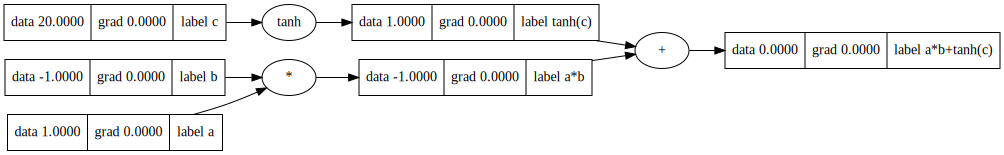

In [94]:
draw_dot(d)

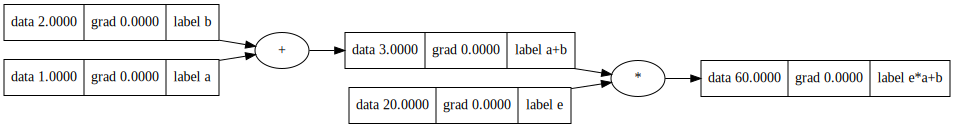

In [105]:
a = Value(1 , label = 'a')
b = Value(2 , label = 'b')
c = a + b
e = Value(20, label = 'e')
d = e*c
draw_dot(d)

In [106]:
d.backward()

Value(data = 60 , label = e*a+b) Value(data = 20 , label = e) Value(data = 3 , label = a+b) Value(data = 2 , label = b) Value(data = 1 , label = a) added


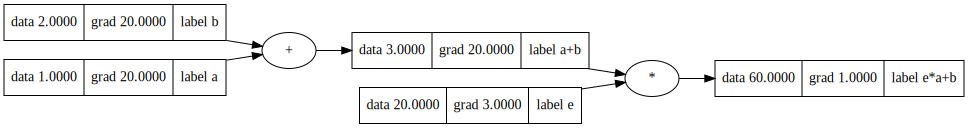

In [107]:
draw_dot(d)

## Neuron

In [35]:
# activation function

# # tanh
# arr = np.arange(-4,4 , 0.5)
# plt.plot(arr , np.tanh(arr))
# plt.grid()

In [52]:
# checking the gradients
# d.grad = 1   # output has 1 grad as its at end
# d._backward()
# we can use dfs to compute all gradients of backprop starting from end node using TopoSort
# we add backward function to Value that recursively compute gradients